## Cluster Analytics


### Import Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from math import sin, cos, pi
from datetime import datetime

# Load datasets
charging_sessions_data = pd.read_csv("cleaned_data.csv")
weather_data = pd.read_csv("weather_burbank_airport.csv")

# Convert the 'timestamp' column in weather_data to datetime format
weather_data["timestamp"] = pd.to_datetime(weather_data["timestamp"])

# Extract date from 'connectionTime' in charging_sessions_data
charging_sessions_data["date"] = pd.to_datetime(charging_sessions_data["connectionTime"]).dt.date
weather_data["date"] = weather_data["timestamp"].dt.date

# Merge weather data into charging_sessions_data on the 'date' column
charging_sessions_data = charging_sessions_data.merge(
    weather_data[["date", "temperature", "precipitation"]],
    on="date",
    how="left"
)

# Check the merged dataset
print(charging_sessions_data.head())

# Data Preprocessing
## Calculate session metrics
charging_sessions_data["session_duration"] = (
    pd.to_datetime(charging_sessions_data["disconnectTime"]) - pd.to_datetime(charging_sessions_data["connectionTime"])
).dt.total_seconds() / 3600

charging_sessions_data["idle_time"] = (
    pd.to_datetime(charging_sessions_data["disconnectTime"]) - pd.to_datetime(charging_sessions_data["doneChargingTime"])
).dt.total_seconds() / 3600

charging_sessions_data["energy_ratio"] = (
    charging_sessions_data["kWhDelivered"] / charging_sessions_data["kWhRequested"]
)

# Add time-based features
charging_sessions_data["hour"] = pd.to_datetime(charging_sessions_data["connectionTime"]).dt.hour
charging_sessions_data["hour_sin"] = charging_sessions_data["hour"].apply(lambda x: sin(2 * pi * x / 24))
charging_sessions_data["hour_cos"] = charging_sessions_data["hour"].apply(lambda x: cos(2 * pi * x / 24))
charging_sessions_data["weekday"] = pd.to_datetime(charging_sessions_data["connectionTime"]).dt.weekday


                         id             connectionTime  \
0  5e23b149f9af8b5fe4b973cf  2020-01-02 13:08:54+00:00   
1  5e23b149f9af8b5fe4b973cf  2020-01-02 13:08:54+00:00   
2  5e23b149f9af8b5fe4b973cf  2020-01-02 13:08:54+00:00   
3  5e23b149f9af8b5fe4b973cf  2020-01-02 13:08:54+00:00   
4  5e23b149f9af8b5fe4b973cf  2020-01-02 13:08:54+00:00   

              disconnectTime           doneChargingTime  kWhDelivered  \
0  2020-01-02 19:11:15+00:00  2020-01-02 17:31:35+00:00        25.016   
1  2020-01-02 19:11:15+00:00  2020-01-02 17:31:35+00:00        25.016   
2  2020-01-02 19:11:15+00:00  2020-01-02 17:31:35+00:00        25.016   
3  2020-01-02 19:11:15+00:00  2020-01-02 17:31:35+00:00        25.016   
4  2020-01-02 19:11:15+00:00  2020-01-02 17:31:35+00:00        25.016   

                                sessionID  siteID  spaceID    stationID  \
0  1_1_179_810_2020-01-02 13:08:53.870034       1  AG-3F30  1-1-179-810   
1  1_1_179_810_2020-01-02 13:08:53.870034       1  AG-3F30  1-

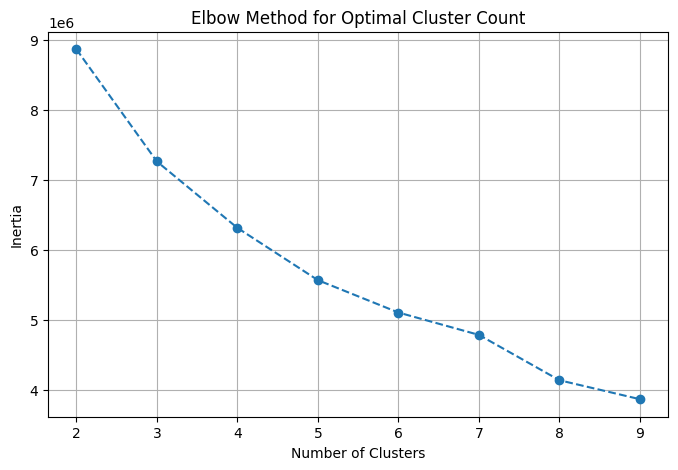

In [2]:
# Feature Selection
features = charging_sessions_data[
    ["session_duration", "idle_time", "energy_ratio", "hour_sin", "hour_cos", "kWhDelivered", "temperature", "precipitation"]
]
features = features.fillna(0)

# Data Scaling
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Elbow Method for optimal clusters
inertia = []
k_values = range(2, 10)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, marker="o", linestyle="--")
plt.title("Elbow Method for Optimal Cluster Count")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.grid()
plt.show()



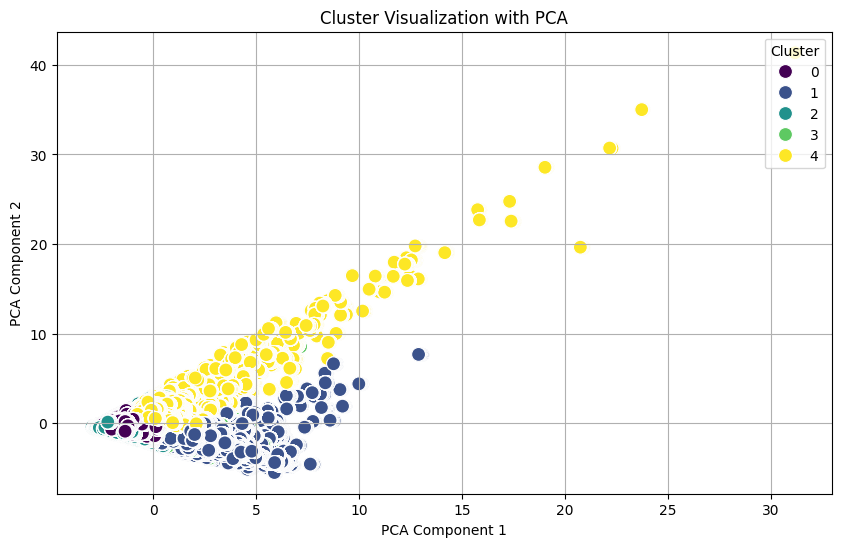

In [3]:
# Clustering with optimal number of clusters (e.g., 5)
optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
charging_sessions_data["cluster"] = kmeans.fit_predict(scaled_features)

# PCA for visualization
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(scaled_features)

# Scatterplot for PCA visualization of clusters
plt.figure(figsize=(10, 6))  # Increase plot size
sns.scatterplot(
    x=reduced_features[:, 0],
    y=reduced_features[:, 1],
    hue=charging_sessions_data["cluster"],
    palette="viridis",
    s=100
)
plt.title("Cluster Visualization with PCA")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster", loc="upper right")  # Specify a fixed legend location
plt.grid()
plt.show()

In [4]:
# Cluster Summarization
cluster_summary = charging_sessions_data.groupby("cluster").agg(
    avg_session_duration=("session_duration", "mean"),
    avg_idle_time=("idle_time", "mean"),
    avg_energy_ratio=("energy_ratio", "mean"),
    avg_kWhDelivered=("kWhDelivered", "mean"),
    avg_temperature=("temperature", "mean"),
    avg_precipitation=("precipitation", "mean"),
    session_count=("cluster", "size")
)

# Display cluster summary
print("Cluster Summary:")
print(cluster_summary)

Cluster Summary:
         avg_session_duration  avg_idle_time  avg_energy_ratio  \
cluster                                                          
0                    3.940115       1.307380          0.439564   
1                    9.208226       2.249810          2.066910   
2                    3.192818       1.185499          0.460799   
3                    6.972741       3.359189          0.717108   
4                    9.605849       5.690115          0.579518   

         avg_kWhDelivered  avg_temperature  avg_precipitation  session_count  
cluster                                                                       
0                7.318742        18.107491           0.023358         433661  
1               34.414053        16.346822           0.039219         140131  
2                7.672301        18.695308           0.023353         203604  
3               11.939851        11.320695           4.884000          10181  
4                9.648967        17.599590    

C:\Users\sk212\AppData\Local\Temp\ipykernel_10664\2439072895.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


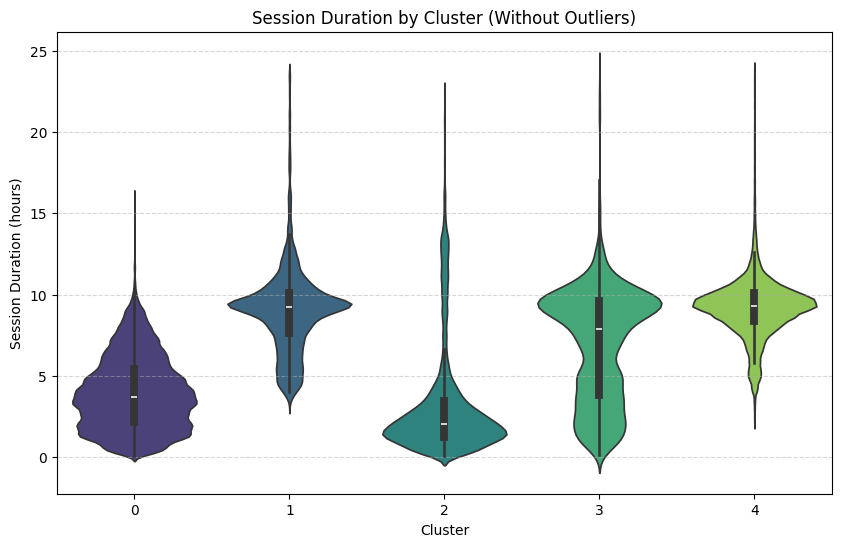

In [5]:
# Filter out outliers (optional, adjust threshold as needed)
threshold = 24  # Max session duration in hours for filtering
filtered_data = charging_sessions_data[charging_sessions_data["session_duration"] <= threshold]

# Create a violin plot without logarithmic scale
plt.figure(figsize=(10, 6))
sns.violinplot(
    x="cluster",
    y="session_duration",
    data=filtered_data,  # Use filtered data to exclude outliers
    inner="box",  # Adds boxplot inside the violin plot
    palette="viridis"
)

# Add titles and labels
plt.title("Session Duration by Cluster (Without Outliers)")
plt.xlabel("Cluster")
plt.ylabel("Session Duration (hours)")

# Add grid lines for clarity
plt.grid(axis="y", linestyle="--", alpha=0.5)

# Show the plot
plt.show()

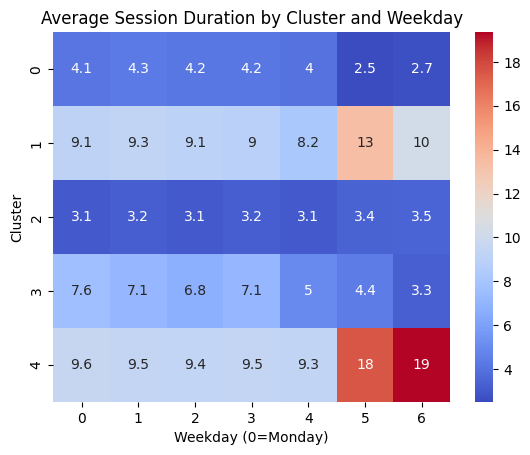

In [6]:
# Heatmap for temporal and spatial trends
time_series = charging_sessions_data.groupby(["cluster", "weekday"])["session_duration"].mean().unstack()
sns.heatmap(time_series, cmap="coolwarm", annot=True)
plt.title("Average Session Duration by Cluster and Weekday")
plt.xlabel("Weekday (0=Monday)")
plt.ylabel("Cluster")
plt.show()

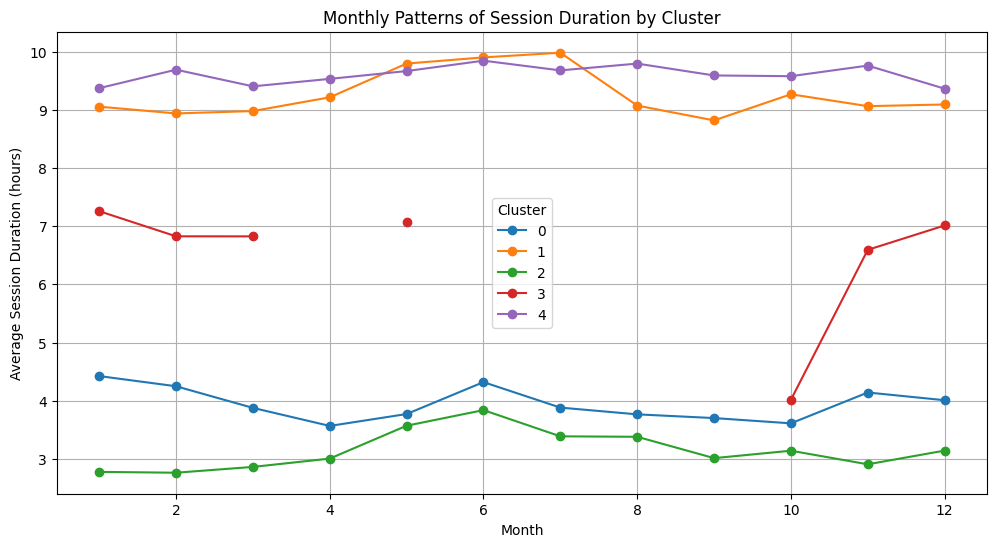

In [7]:
# Time series analysis for seasonal patterns
charging_sessions_data["month"] = pd.to_datetime(charging_sessions_data["connectionTime"]).dt.month
monthly_patterns = charging_sessions_data.groupby(["month", "cluster"])["session_duration"].mean().unstack()

monthly_patterns.plot(kind="line", figsize=(12, 6), marker="o")
plt.title("Monthly Patterns of Session Duration by Cluster")
plt.xlabel("Month")
plt.ylabel("Average Session Duration (hours)")
plt.grid()
plt.legend(title="Cluster")
plt.show()


<Figure size 1200x800 with 0 Axes>

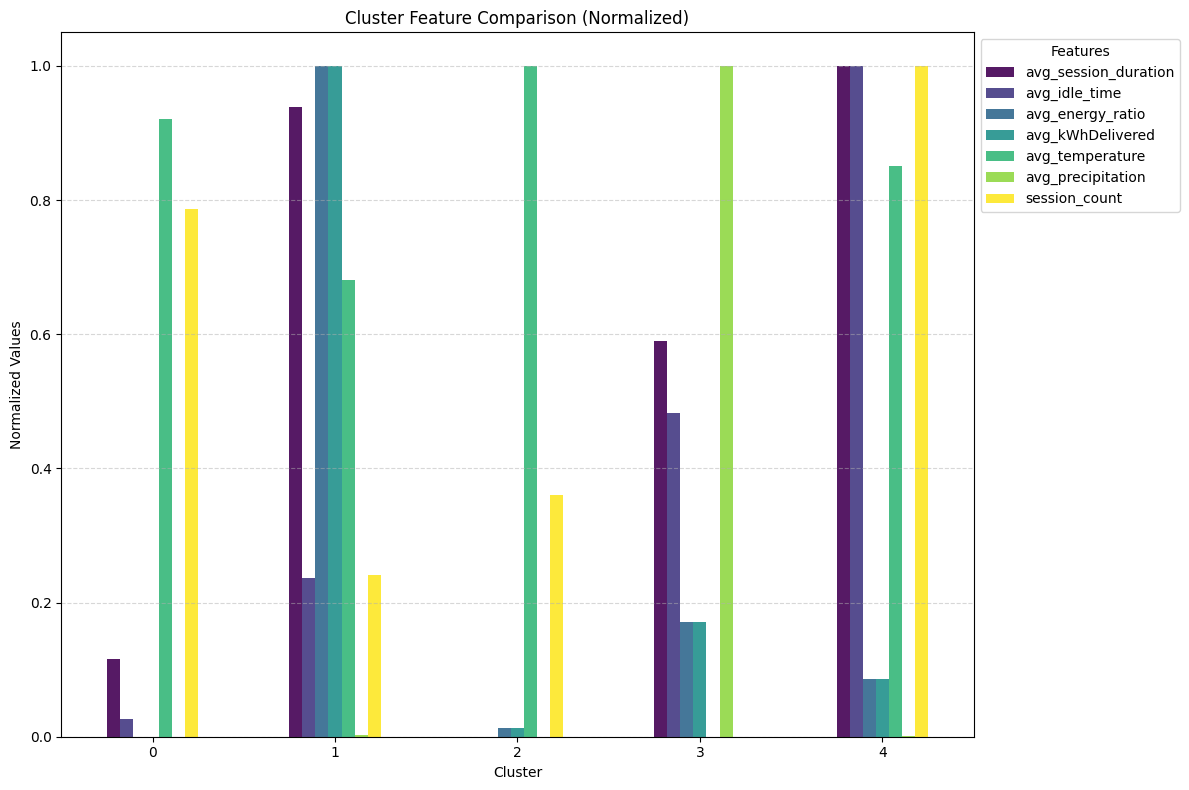

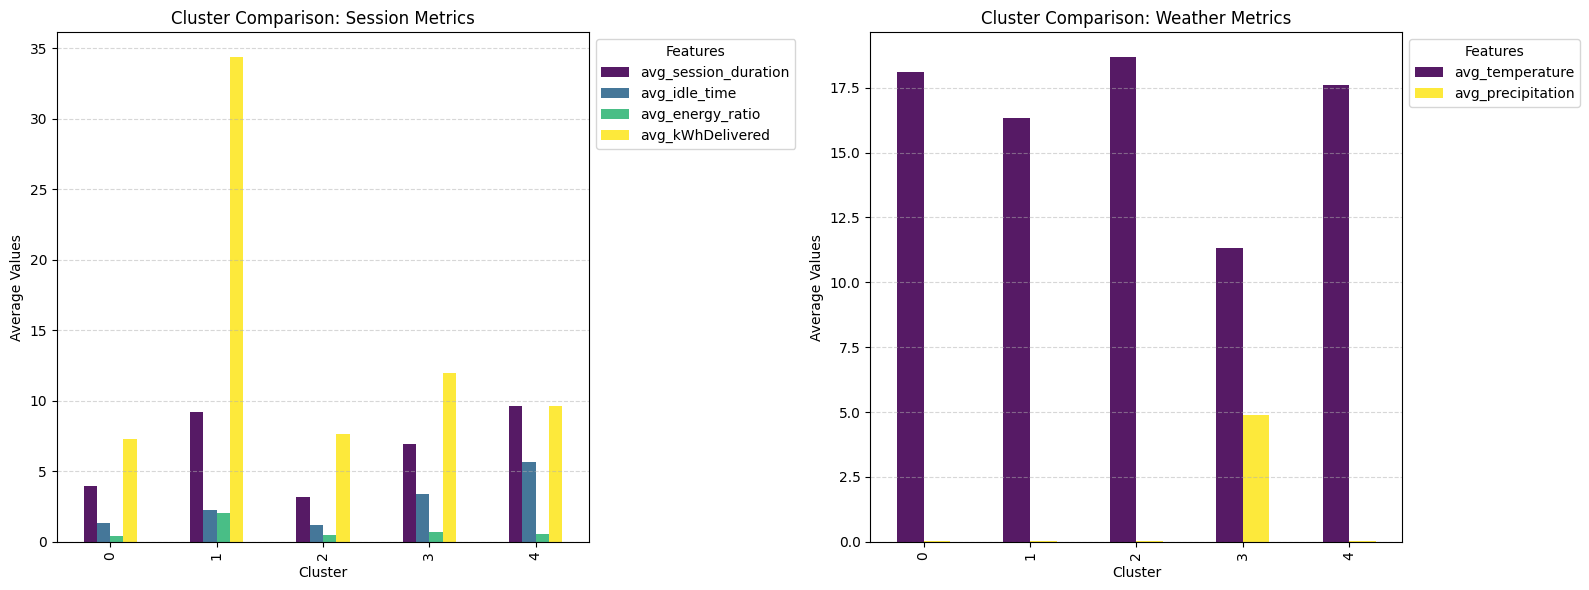

In [8]:
# Normalize data for meaningful comparison
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(cluster_summary)

# Convert to DataFrame for better handling
normalized_df = pd.DataFrame(
    normalized_data,
    columns=cluster_summary.columns,
    index=cluster_summary.index
)

# Plot the normalized data
plt.figure(figsize=(12, 8))
normalized_df.plot(kind="bar", figsize=(12, 8), colormap="viridis", alpha=0.9)
plt.title("Cluster Feature Comparison (Normalized)")
plt.xlabel("Cluster")
plt.ylabel("Normalized Values")
plt.xticks(rotation=0)
plt.legend(loc="upper left", bbox_to_anchor=(1, 1), title="Features")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# Separate Subplots for Session and Weather Metrics
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Session metrics
cluster_summary[["avg_session_duration", "avg_idle_time", "avg_energy_ratio", "avg_kWhDelivered"]].plot(
    kind="bar", ax=axes[0], colormap="viridis", alpha=0.9
)
axes[0].set_title("Cluster Comparison: Session Metrics")
axes[0].set_xlabel("Cluster")
axes[0].set_ylabel("Average Values")
axes[0].legend(loc="upper left", bbox_to_anchor=(1, 1), title="Features")
axes[0].grid(axis="y", linestyle="--", alpha=0.5)

# Weather metrics
cluster_summary[["avg_temperature", "avg_precipitation"]].plot(
    kind="bar", ax=axes[1], colormap="viridis", alpha=0.9
)
axes[1].set_title("Cluster Comparison: Weather Metrics")
axes[1].set_xlabel("Cluster")
axes[1].set_ylabel("Average Values")
axes[1].legend(loc="upper left", bbox_to_anchor=(1, 1), title="Features")
axes[1].grid(axis="y", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()